In [1]:
#https://math.embed.fun/8HzEmimwFL2Fi8uTdiPFqr

# Bayesian Generalized Linear Model Construction with Pyro

One of the most common "first lines of attack" when faced with a predictive or analytical data project is the family of Generalized Linear Models (GLMs), and most commonly the linear or logistic regressions.

GLMs seek to model a response variable, $y$, as a function of a linear combination of features $X$. The reason for the linear combination is largely for the purpose of explainability; We want to not only be able to predict $y$ well, but also be able to explain what is the effect of each feature on our response.

Thus, we usually specify a GLM as our response being a combination of features and coefficients as follows:

$$y = f(\beta_0 + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n)$$

Where the coefficients are denoted with the Greek letter $\beta$


While libraries such as `sklearn` offer a rich variety of regression models, they have one major drawback in that they create point estimates of $\beta$ without taking uncertainty into account. That is, while we can find out what are the most likely values for the coefficient, we don't estimate how likely are other values for the coefficients. Other packages such as `statsmodels` offer some measure of uncertainty, but do so under a series of implicit assumptions the analyst may not get to verify

In this article we'll discuss how to leverage PyTorch and Pyro to produce GLM models which create uncertainty estimates both for the parameters, as well as for predictions, and do so with a set of very explicit assumptions

## Employing Scikit-learn's Linear Regression

We'll start by exploring a simple linear regression from `sklearn`, and see how it behaves on one of the built in datasets in `sklearn`, the California Housing dataset.

We'll start by importing all our required libraries

In [2]:
import numpy as np
import time
np.set_printoptions(suppress=True)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# TO DELETE
super_start = time.time()

try:
    super_results = pd.read_csv('experimental_measurement.csv')
except:
    super_results = pd.DataFrame({'model' :[], 
                     'measurement': [], 
                     'censored': [],
                     'value': []})

super_results.tail()

model measurement  censored      value
595  MCMC scaled gamma         R^2       1.0   0.661423
596  MCMC scaled gamma         R^2       0.0   0.573882
597   SVI scaled gamma        time       1.0  44.150000
598   SVI scaled gamma         R^2       1.0   0.659317
599   SVI scaled gamma         R^2       0.0   0.578836

Now let's import the housing dataset, and explore its features

In [4]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()

X = california.data
y = california.target * 100000

print(f'Data shape is {X.shape}')
print(f'Target shape is {y.shape}')

Data shape is (20640, 8)
Target shape is (20640,)


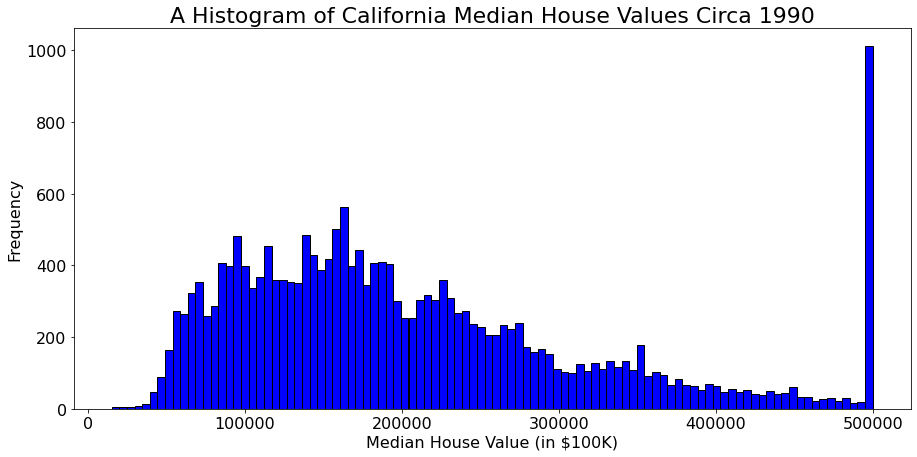

In [5]:
plt.figure(figsize=(15,7))
plt.hist(y, bins=100, color="blue", edgecolor="black")
plt.xlabel("Median House Value (in $100K)", size=16)
plt.ylabel("Frequency", size=16)
plt.title("A Histogram of California Median House Values Circa 1990", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.savefig("images/HouseValues.png", dpi=36*4)
plt.show()



The base linear regression model in many libraries assumes the response is normally distributed around the predicted means. However, generally house prices won't be normally distributed. In this dataset as well, the distribution of prices is not normal, it is closer to a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). So it would be nice if we were able to build our model so it takes that into account.

First, let's explore how well an `sklearn` linear regression performs on this data. We can split the data into train and test sets to get an estimate of how our algorithms will work

In [6]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


Let's fit our linear regression:

In [8]:
start_time = time.time()

my_linear_regression = LinearRegression().fit(X_train,y_train)

y_pred = my_linear_regression.predict(X_test)

end_time = time.time()


print(f"beta_intercept: {round(my_linear_regression.intercept_, 2)}")
for i, col in enumerate(california.feature_names):
    print(f"beta_{col}: {round(my_linear_regression.coef_[i], 2)}")

beta_intercept: -3579463.0
beta_MedInc: 45221.83
beta_HouseAge: 942.89
beta_AveRooms: -12918.91
beta_AveBedrms: 67141.71
beta_Population: -0.46
beta_AveOccup: -353.44
beta_Latitude: -40673.03
beta_Longitude: -42082.71


In [9]:
# TO DELETE
new_measurements = pd.Series({"model": "Linear Regression", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored      value
596  MCMC scaled gamma         R^2       0.0   0.573882
597   SVI scaled gamma        time       1.0  44.150000
598   SVI scaled gamma         R^2       1.0   0.659317
599   SVI scaled gamma         R^2       0.0   0.578836
600  Linear Regression        time       1.0   0.010000

Let's define a function to plot our predictions and the true values for the held out test set:

In [10]:
def plot_all_observations(y_true, y_pred, y_max, fig_name):
    
    y_pred_censored = np.where(y_pred > y_max, y_max, y_pred)
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_censored, y_test, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test, y_pred_censored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.savefig("images/"+fig_name+".png", dpi=96)
    plt.show()

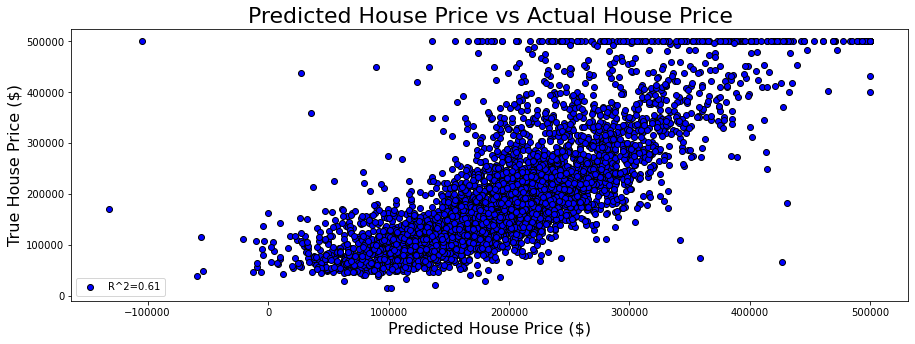

In [11]:
plot_all_observations(y_test, y_pred, y_train.max(), "01_censored_LR")

There are some observations in our data which are censored. That is, their label seems to be houses which cost $500,000+. We can define another function which plots all points which are not censored:

In [12]:
y_censor_label = y_train.max()

In [13]:
# TO DELETE
def plot_uncensored_observations(y_true, y_pred, y_censor_label, fig_name):
    
    y_test_uncensored = y_test[y_test<y_censor_label]
    y_pred_uncensored = y_pred[y_test<y_censor_label]
    
    plt.figure(figsize=(15, 5))
    plt.scatter(y_pred_uncensored, y_test_uncensored, 
                c="blue", edgecolor="black", 
                label=f'R^2={round(r2_score(y_test_uncensored, y_pred_uncensored),2)}')
    
    plt.title("Predicted House Price vs Actual House Price", size=22)
    plt.xlabel("Predicted House Price ($)", size=16)
    plt.ylabel("True House Price ($)", size=16)
    plt.ticklabel_format(style='plain')
    plt.legend()
    
    plt.savefig("images/"+fig_name+".png", dpi=96)
    plt.show()

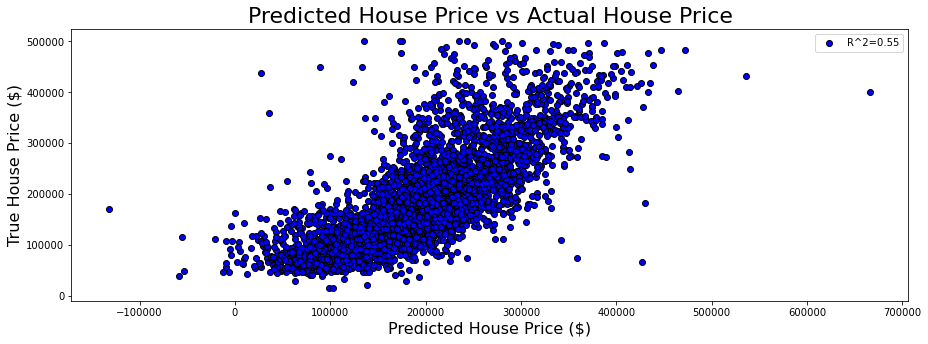

In [14]:
# TO DELETE
plot_uncensored_observations(y_test, y_pred, y_censor_label, "02_uncensored_LR")

In [15]:
# TO DELETE
y_pred_censored = np.where(y_pred > y_censor_label, y_censor_label, y_pred)

new_measurements = pd.Series({"model": "Linear Regression", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored      value
597   SVI scaled gamma        time       1.0  44.150000
598   SVI scaled gamma         R^2       1.0   0.659317
599   SVI scaled gamma         R^2       0.0   0.578836
600  Linear Regression        time       1.0   0.010000
601  Linear Regression         R^2       1.0   0.605021

In [16]:
# TO DELETE
y_test_uncensored = y_test[y_test<y_censor_label]
y_pred_uncensored = y_pred[y_test<y_censor_label]


new_measurements = pd.Series({"model": "Linear Regression", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored     value
598   SVI scaled gamma         R^2       1.0  0.659317
599   SVI scaled gamma         R^2       0.0  0.578836
600  Linear Regression        time       1.0  0.010000
601  Linear Regression         R^2       1.0  0.605021
602  Linear Regression         R^2       0.0  0.550628

While this approach can produce satisfactory results, it suffers from a few main drawbacks; 

* First, the linear model generally ignore the fact that the prices come from a Gamma distribution. Its calculations of the expected value for every point are predicated on the mean coming from a Normal distribution. 
* Second, for each coefficient, we only get a point estimate of its most likely value. However, we might be interested in a range which accounts for uncertainty. For example, we might want to know what is the range of price increases we can expect for each additional bedroom.

To address these problems, we can employ Pyro and PyTorch to construct our own linear model which will address all the pain points just mentioned. 

## Step I - Reconstructing the Linear Model with Pyro

First, let's try and replicate the findings of the simple linear regression with Pyro. This will give us an intuition for how the different Pyro primitives work

In [17]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

First, we will define our model in Pyro. Pyro models are defined as functions (actually they are defined as callables, but the simplest callable is a function). The function will accept our features $X$, our target $y$, and also the feature names for easier naming of priors.

In [18]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma value for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=10.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In essence what we've done here is define our linear regression as the following linear combination of parameters


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \mathcal{N}(0, \sigma^2)$$

However, unlike traditional linear regressions, we've defined each beta coefficient, as well as the error term, to be a distribution instead of a single values. That is, for each coefficient, we can ask what is the range of possible values this coefficient can assume given the data we observed. We gave a name to each of those distributions (e.g. "`beta_intercept`") for easy reference later.

We had to define priors on each coefficient. A prior is like our "best guess" for that value. Our chosen priors were:

$$\beta_i \sim \mathcal{N}(0, 1^2)$$<br>
$$\sigma \sim \text{HalfNormal}(0.0, 10^2)$$<br>

One important point to notice is that we have to be explicit about these choices when building our model. That is, we have to be clear about what are reasonable priors for the coefficient values, the error term, and the distribution of values around our predicted value.

Once the priors are defined, we can ask Pyro to update them into better and better guesses through the magic of MCMC samplers:

In [19]:
SAMPLE_NUMBER = 3000


# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.tensor(X_train)
y_train_torch = torch.tensor(y_train)



# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             california.feature_names)

end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [26:29,  1.95it/s, step size=1.44e-03, acc. prob=0.867]

Inference ran for 26.49 minutes


In [20]:
# TO DELETE
new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
599      SVI scaled gamma         R^2       0.0     0.578836
600     Linear Regression        time       1.0     0.010000
601     Linear Regression         R^2       1.0     0.605021
602     Linear Regression         R^2       0.0     0.550628
603  MCMC unscaled normal        time       1.0  1589.180000

If you are interested in a breakdown of what has happened here, I recommend that you check out [my previous post](https://towardsdatascience.com/probabilistic-programming-with-pyro-and-kitchen-scale-f8d6a5d9ae0f) which explores the use of MCMC methods to optimize a single parameter.

We can explore the estimates found by our MCMC sampler for each of our coefficients using the `.summary()` method:

In [21]:
my_mcmc1.summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta_intercept      1.95      0.01      1.95      1.93      1.97      3.93      1.31
      beta_MedInc      1.99      0.02      1.99      1.97      2.02      4.68      1.88
    beta_HouseAge      0.66      0.11      0.65      0.48      0.82      2.82      2.16
    beta_AveRooms      0.08      0.02      0.08      0.05      0.12      2.87      2.62
   beta_AveBedrms      0.96      0.03      0.96      0.92      1.00      4.20      1.02
  beta_Population     85.03     10.23     87.25     86.49     88.10     21.31      1.03
    beta_AveOccup     -0.97      0.03     -0.98     -1.02     -0.92      3.37      1.81
    beta_Latitude      1.71      0.31      1.72      1.25      2.15      2.45      2.87
   beta_Longitude    -17.19      9.77    -16.99    -30.66     -1.48      2.50      2.67
            sigma  14911.55    212.98  14868.83  14829.06  14906.77     17.12      1.09

Number of divergences: 0


Those don't look quite right... The means seem very different from the point estimates found by the regression from `sklearn`.

Let's grab the individual samples from our sampler, and turn those into a dataframe (they are returned as a dictionary).
We can grab the mean of each distribution as a coefficient point estimate, and then calculate a set of predictions for our data points. Then, we can compare them to our known values for house prices

In [22]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

beta_intercept  beta_MedInc  beta_HouseAge  beta_AveRooms  beta_AveBedrms  \
0        1.943842     1.991298       0.483603       0.115008        0.921994   
1        1.943823     1.991372       0.483581       0.115012        0.921911   
2        1.943810     1.991376       0.483591       0.115015        0.921895   
3        1.943851     1.991423       0.483640       0.115093        0.921913   
4        1.943847     1.991467       0.483650       0.115147        0.921932   

   beta_Population  beta_AveOccup  beta_Latitude  beta_Longitude         sigma  
0        25.640257      -0.985786       1.253573       -1.481469  16306.978516  
1        25.685791      -0.985715       1.253564       -1.481270  16314.896484  
2        25.707136      -0.985699       1.253619       -1.481101  16307.180664  
3        25.897057      -0.985820       1.253872       -1.480773  16310.462891  
4        25.916445      -0.985798       1.253862       -1.480955  16297.495117

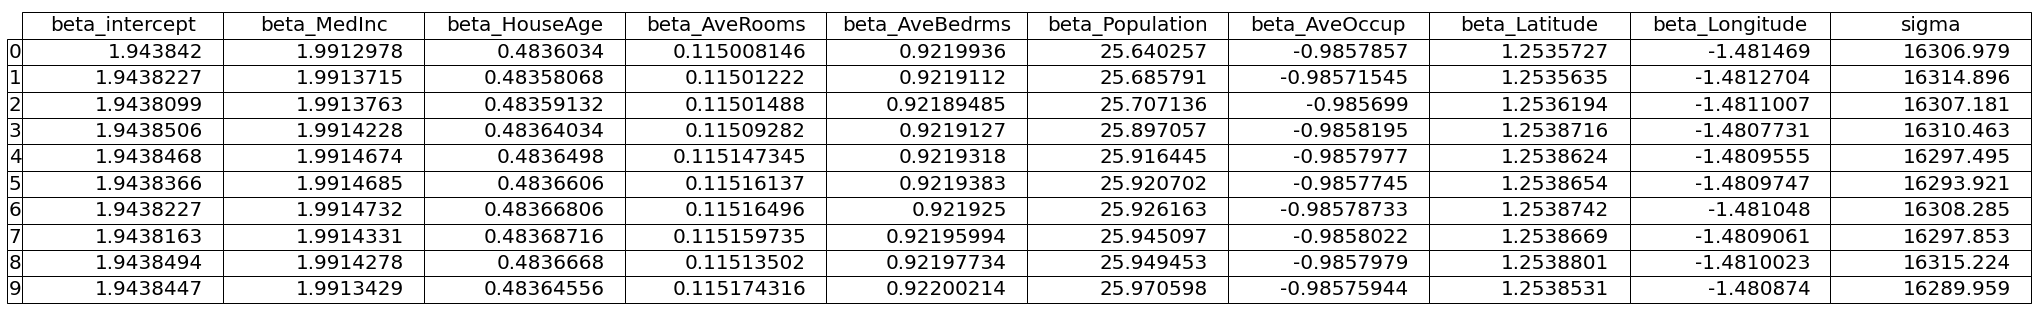

In [23]:
# TO DELETE
from pandas.plotting import table # EDIT: see deprecation warnings below

plt.figure(figsize=(30,5))
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

tabla = table(ax, beta_df.head(10), loc='upper center')  # where df is your data frame

tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(20) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 2.2) # change size table

plt.savefig('images/coef_table.png', dpi=96)
plt.show()

In [24]:
# TO DELETE
#https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png

In [25]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    coefficients = beta_df.iloc[:, :-1].mean()

    # Find our linear combination again
    linear_combination = X.dot(coefficients[1:]) + coefficients.iloc[0]
    
    return linear_combination

In [26]:
linear_combination = predict_linear_combination(beta_df, X_test)

In [27]:
# Our predictions are the linear combination
y_pred = linear_combination

Let's plot the results and calculate the $R^2$ value for our predictions:

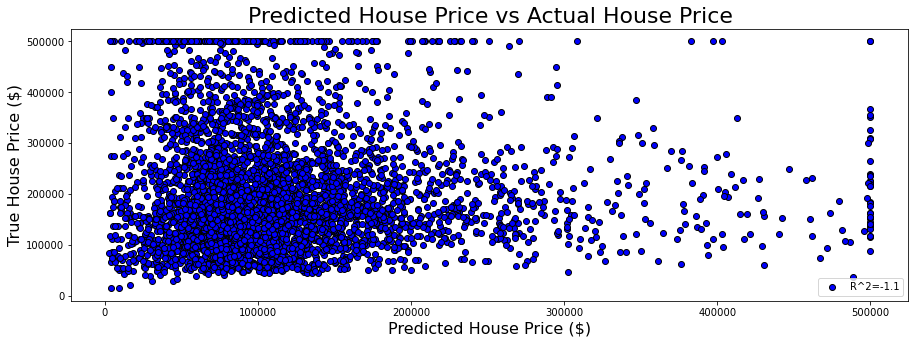

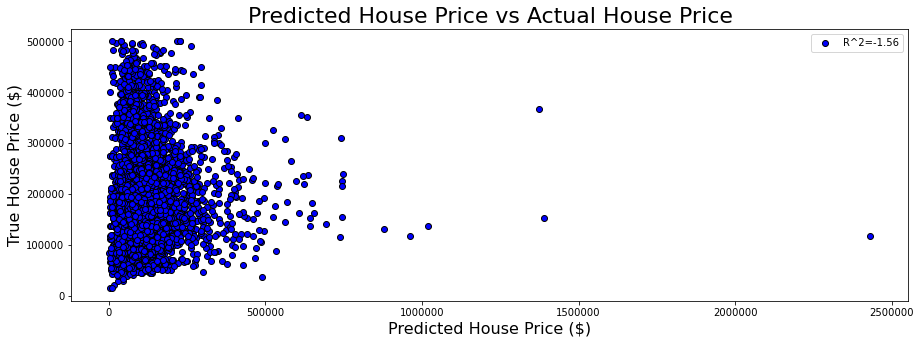

In [28]:
plot_all_observations(y_test, y_pred, y_censor_label, "03_censored_normal_unsacled")
plot_uncensored_observations(y_test, y_pred, y_censor_label, "04_uncensored_normal_unsacled")

In [29]:
# TO DELETE
y_pred_censored = np.where(y_pred > y_censor_label, y_censor_label, y_pred)


new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
600     Linear Regression        time       1.0     0.010000
601     Linear Regression         R^2       1.0     0.605021
602     Linear Regression         R^2       0.0     0.550628
603  MCMC unscaled normal        time       1.0  1589.180000
604  MCMC unscaled normal         R^2       1.0    -1.098245

In [30]:
# TO DELETE
y_test_uncensored = y_test[y_test<y_censor_label]
y_pred_uncensored = y_pred[y_test<y_censor_label]

r2 = r2_score(y_test_uncensored, y_pred_uncensored)

new_measurements = pd.Series({"model": "MCMC unscaled normal", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
601     Linear Regression         R^2       1.0     0.605021
602     Linear Regression         R^2       0.0     0.550628
603  MCMC unscaled normal        time       1.0  1589.180000
604  MCMC unscaled normal         R^2       1.0    -1.098245
605  MCMC unscaled normal         R^2       0.0    -1.560033

Well that looks like a disaster! What happened?

Let's define a function that will draw the coefficients' distributions for us when given a coefficient dataframe

In [31]:
def draw_coefficients(beta_df, fig_name):
    figure, axis = plt.subplots(5,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    
    plt.savefig("images/"+fig_name+".png", dpi=96)
    plt.show()

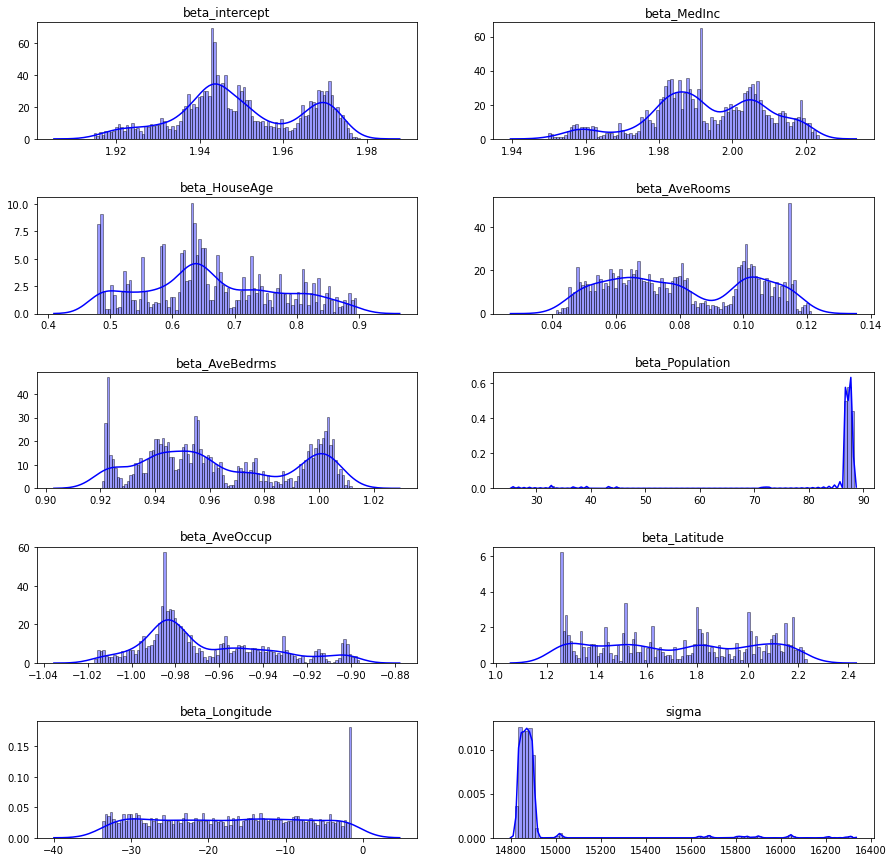

In [32]:
draw_coefficients(beta_df, "05_normal_unscaled_coefficients")

Those plots don't look like they converged.

Turns out MCMC methods have a hard time with different scales for our data. They work much better when our features and target are scaled. Let's explore the performance of the same methodology with the data scaled

## Scaling Our Data

We are going to scale our X and y data using a standard scaler from `sklearn`. The standard scaler will scale each feature in X in such a way that it has a mean of 0.0, and a standard deviation of 1.0. To do so it will employ each variable's mean $\bar{x}$ and standard deviation $s$

This means, instead of trying to find a set of coefficients on the original data


$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n $$

we will find a set of coefficients on the scaled data:

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n} $$

Where 

$$y' = \frac{y}{y_{max}}$$

That is, y is scaled to be between 0-1 and the columns of X have been standardized.

In [33]:
from sklearn.preprocessing import StandardScaler


# Scale X
my_x_scaler = StandardScaler()
X_train_scaled = my_x_scaler.fit_transform(X_train)

# Scale y
y_censor_label = y_train.max()
y_train_scaled = y_train/y_censor_label

In [34]:
# Convert our data into pytorch tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)


# Clear previous parameters
pyro.clear_param_store()

# Perform inference again
my_kernel2 = NUTS(model_normal, max_tree_depth=7)

my_mcmc2 = MCMC(my_kernel2,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


start_time = time.time()
my_mcmc2.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [05:12,  9.93it/s, step size=3.22e-03, acc. prob=0.917]

Inference ran for 5.2 minutes


In [35]:
# TO DELETE
new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
602     Linear Regression         R^2       0.0     0.550628
603  MCMC unscaled normal        time       1.0  1589.180000
604  MCMC unscaled normal         R^2       1.0    -1.098245
605  MCMC unscaled normal         R^2       0.0    -1.560033
606    MCMC scaled normal        time       1.0   312.210000

Our algorithm ran much faster now, but if we recover the coefficients the algorithm found, those will be the coefficients on the scaled data. We would like to translate them back into the unscaled data so we can ask questions such as: "For each extra bedroom in the house, what will be the effect on the price?"


Luckily, we can manipulate our equation to retrieve the coefficients on the unscaled data. We begin with our original equation

$$y' = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n} $$

and we expand each fraction:

$$y' = \beta'_0 + \beta'_1\frac{x_1}{s_1} - \beta'_1\frac{\bar{x}_1}{s_1} + \beta'_2\frac{x_2}{s_2} - \beta'_2\frac{\bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n}{s_n} - \beta'_n\frac{\bar{x}_n}{s_n} $$

We can then rearrange the equation as follows:

$$y' = \beta'_0 - \beta'_1\frac{\bar{x}_1}{s_1} - \beta'_2\frac{\bar{x}_2}{s_2} ... - \beta'_n\frac{\bar{x}_n}{s_n} + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n  $$

Recalling that 

$$y' = \frac{y}{y_{max}}$$

we can finally rewrite our formula as follows:

$$y = y_{max}\big( \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1 y_{max}}{s_1}x_1 + \frac{\beta'_2 y_{max}}{s_2}x_2 + ... + \frac{\beta'_n y_{max}}{s_n}x_n  $$

We can create a function to perform the processing of the coefficients from the scaled data to the unscaled data

In [36]:
def create_beta_df(beta_df, x_scaler, feature_names):        
    
    i = 0
    for col in beta_df:
        if (col != 'beta_intercept'):
            if ('beta_' in col):

                beta_df['beta_intercept'] -= (beta_df[col] * x_scaler.mean_[i])/x_scaler.scale_[i]                
                beta_df[col] /= x_scaler.scale_[i]
                i += 1

    return beta_df

Then we just employ that function on the retrieved coefficients after we retrieve them from the dictionary again.

In [37]:
beta2_df = pd.DataFrame(my_mcmc2.get_samples())
#my_kernel.cleanup()
beta2_df = create_beta_df(beta2_df, my_x_scaler, california.feature_names)
beta2_df *= y_censor_label   # multiply everything by y_max outside the function for reasons that will
                             # become clear later

Let's compare the prediction results

In [38]:
linear_combination = predict_linear_combination(beta2_df, X_test)

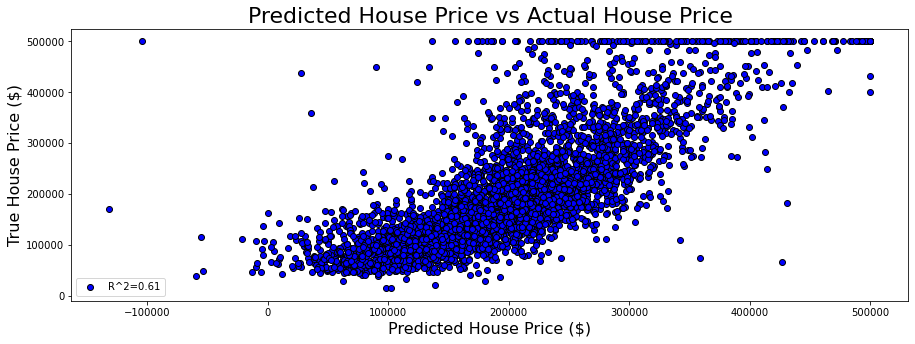

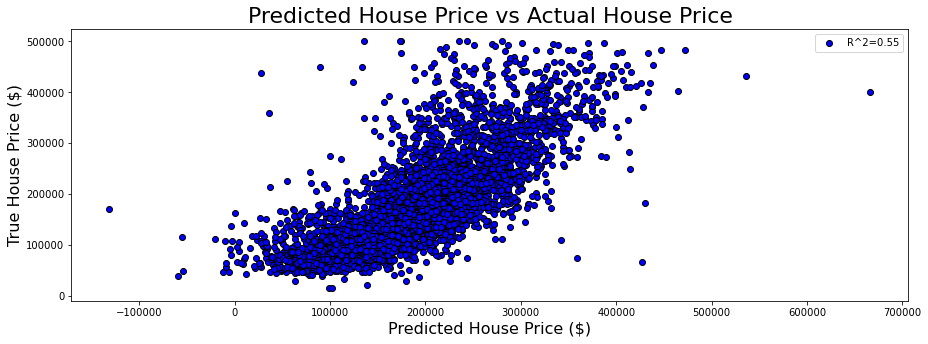

In [39]:
y_pred = linear_combination

plot_all_observations(y_test, y_pred, y_censor_label, "06_censored_normal_scaled")
plot_uncensored_observations(y_test, y_pred, y_censor_label, "07_uncensored_normal_scaled")

These values seem much closer to the values found by the linear regression from `sklearn`. 

In [40]:
# TO DELETE
y_pred_censored = np.where(y_pred > y_censor_label, y_censor_label, y_pred)
new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
603  MCMC unscaled normal        time       1.0  1589.180000
604  MCMC unscaled normal         R^2       1.0    -1.098245
605  MCMC unscaled normal         R^2       0.0    -1.560033
606    MCMC scaled normal        time       1.0   312.210000
607    MCMC scaled normal         R^2       1.0     0.605033

In [41]:
# TO DELETE
y_test_uncensored = y_test[y_test<y_censor_label]
y_pred_uncensored = y_pred[y_test<y_censor_label]


new_measurements = pd.Series({"model": "MCMC scaled normal", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored       value
604  MCMC unscaled normal         R^2       1.0   -1.098245
605  MCMC unscaled normal         R^2       0.0   -1.560033
606    MCMC scaled normal        time       1.0  312.210000
607    MCMC scaled normal         R^2       1.0    0.605033
608    MCMC scaled normal         R^2       0.0    0.550636

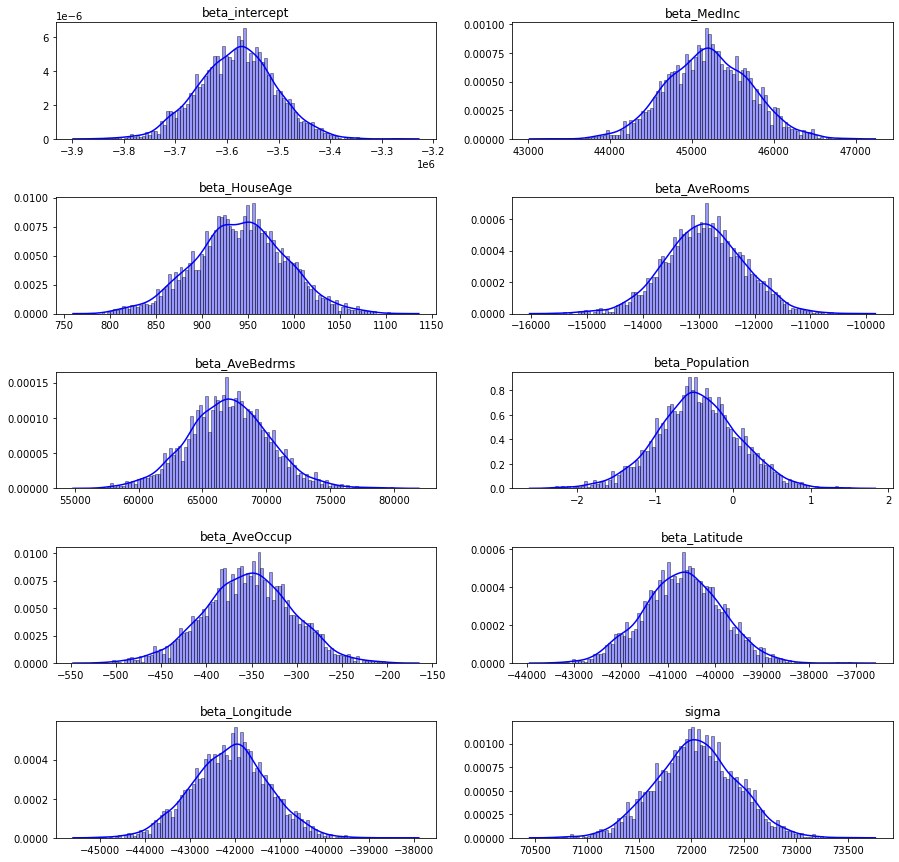

In [42]:
draw_coefficients(beta2_df, "08_normal_scaled_coefficients")

It seems like we got a comparable performance. The distributions look close to the values we got from scikit-learn.
We also get a probability distribution for each coefficient so we can see our level of confidence in the value we found.

However, we can actually employ Pyro to do better! Recall that we saw our house prices are not normally distributed but in fact follow a Gamma distribution. We can modify our code to reflect that in the model.

## Improving our Predictions Using a Gamma Distribution

In order to better reflect the house distribution, we can employ a Gamma distribution for our target values. Unlike the Normal distribution which is defined by its mean and standard deviation, the Gamma distribution is defined by two positive parameters which are the shape and the rate.

When constructing our model for a distribution other than normal, we need to employ a **link function** which will translate the linear combination of our parameters to the expected value, or the mean, of the distribution. We also would like to know the relationship between the mean and the distribution parameters. Luckily, for the Gamma distribution this is predefined as:

$$\mu = mean = \frac{shape}{rate}$$

However, if both the shape and rate parameters are positive, that means the mean must be positive as well. We need to make sure that our link function captures that. Therefore, I will use the following link function for the linear equation:

$$ln(y') = \beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n}$$

or 

$$y' = e^{\beta'_0 + \beta'_1\frac{x_1 - \bar{x}_1}{s_1} + \beta'_2\frac{x_2 - \bar{x}_2}{s_2} + ... + \beta'_n\frac{x_n - \bar{x}_n}{s_n}}$$


Interestingly enough, to recover the coefficients for the unscaled data, the math works out fairly similarly except for the constant. Keeping in mind that:

$$y' = \frac{y}{y_{max}} = \frac{\mu}{y_{max}}$$

and that

$$ln(\frac{y}{max(y)}) = ln(y) - ln(y_{max})$$

We can find that our equation can be written as:

$$ln(y) = \big(ln(y_{max}) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n  $$

or 

$$\mu = y = e^{\big(ln(y_{max}) + \beta'_0 - \sum_{i=1}^n\beta'_i\frac{\bar{x}_i}{s_i} \big) + \frac{\beta'_1}{s_1}x_1 + \frac{\beta'_2}{s_2}x_2 + ... + \frac{\beta'_n}{s_n}x_n}$$

Let's define our model, but now using a gamma distribution:

In [43]:
def model_gamma(X, y, column_names):
    pyro.enable_validation(True)
    
    min_value = torch.finfo(X.dtype).eps
    max_value = torch.finfo(X.dtype).max
    
    # We still need to calculate our linear combination
    
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    #print("intercept", linear_combination)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        
        #print(column_names[i], beta_coef)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
        
    # But now our mean will be e^{linear combination}    
    mean = torch.exp(linear_combination).clamp(min=min_value, max=max_value)
    
    # We will also define a rate parameter
    rate = pyro.sample("rate", dist.HalfNormal(scale=10.0)).clamp(min=min_value)
    
    # Since mean = shape/rate, then the shape = mean * rate
    shape = (mean * rate)
    
    
    
    # Now that we have the shape and rate parameters for the
    # Gamma distribution, we can draw samples from it and condition
    # them on our observations
    with pyro.plate("data", y.shape[0]):
        
        outcome_dist = dist.Gamma(shape, rate)
        
        observation = pyro.sample("obs", outcome_dist, obs=y)

You'll notice our code is slightly different but we are still calculating a linear combination of our `X` data and our coefficients, except now we take the `exp` of that combination to get the mean value of our data point. 
We also sample a rate parameter, and use the mean and rate to calculate the appropriate shape parameter.

Given our shape and rate parameters, we can define a gamma distribution and ask Pyro to optimize our coefficients and rate parameters in order to build a model most likely based on our data.

Let's optimize this new model and look at the results:

In [44]:
## Again scale our X data
#my_x_scaler = StandardScaler()
#X_train_scaled = my_x_scaler.fit_transform(X_train)
#
## Scale our y data
#y_max = y_train.max()
#y_train_scaled = y_train/y_max
#
## Convert our data into pytorch tensors
#X_train_torch = torch.tensor(X_train_scaled)
#y_train_torch = torch.tensor(y_train_scaled)

# Clear all previous runs of pyro
pyro.clear_param_store()

# And finally, perform inference
my_kernel3 = NUTS(model_gamma, max_tree_depth=7)


my_mcmc3 = MCMC(my_kernel3,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)



start_time = time.time()
my_mcmc3.run(X_train_torch,
             y_train_torch,
             california.feature_names)
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [29:16,  1.77it/s, step size=4.51e-03, acc. prob=0.962]

Inference ran for 29.27 minutes


In [45]:
# TO DELETE
new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
605  MCMC unscaled normal         R^2       0.0    -1.560033
606    MCMC scaled normal        time       1.0   312.210000
607    MCMC scaled normal         R^2       1.0     0.605033
608    MCMC scaled normal         R^2       0.0     0.550636
609     MCMC scaled gamma        time       1.0  1756.200000

We can grab the coefficients from this sampler as well. However, this time we have to treat the value of `y_max` slightly differently.

In [46]:
beta3_df = pd.DataFrame(my_mcmc3.get_samples())
#my_kernel.cleanup()
beta3_df = create_beta_df(beta3_df, my_x_scaler, california.feature_names)

# Notice now we have to use the y_max value slightly differently
beta3_df['beta_intercept'] += np.log(y_censor_label)

Let's compare this model's performance by calculating the predictions and comparing them to the observed values

In [47]:
linear_combination = predict_linear_combination(beta3_df, X_test)

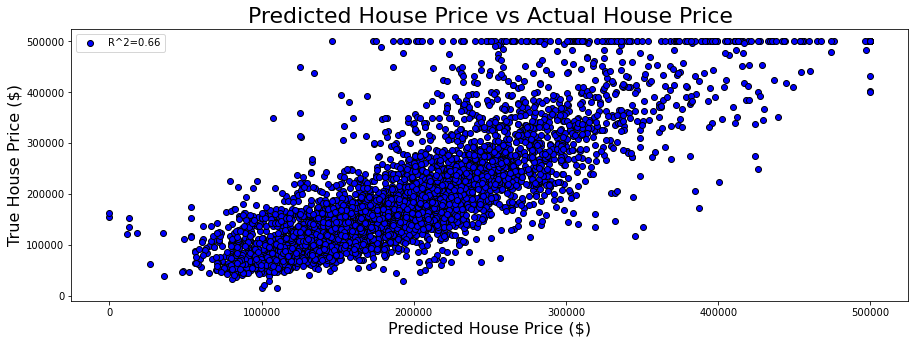

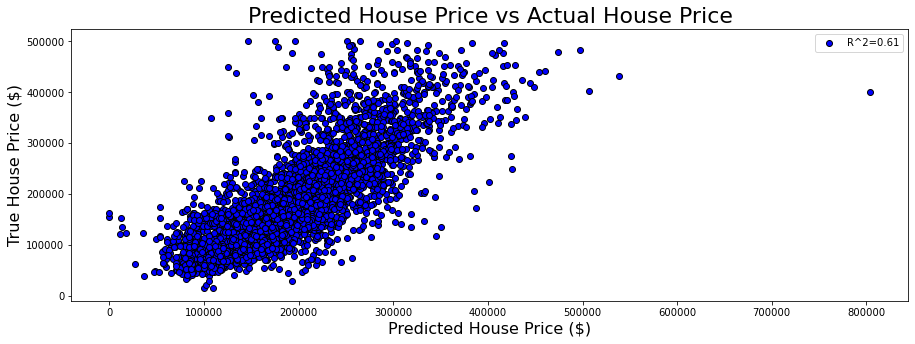

In [48]:
# We have to take the EXP of the linear combination now to get the expected values
y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label, "09_censored_gamma_scaled")
plot_uncensored_observations(y_test, y_pred, y_censor_label, "10_uncensored_gamma_scaled")

In [49]:
# TO DELETE
y_pred_censored = np.where(y_pred > y_censor_label, y_censor_label, y_pred)

new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
606  MCMC scaled normal        time       1.0   312.210000
607  MCMC scaled normal         R^2       1.0     0.605033
608  MCMC scaled normal         R^2       0.0     0.550636
609   MCMC scaled gamma        time       1.0  1756.200000
610   MCMC scaled gamma         R^2       1.0     0.662587

In [50]:
# TO DELETE
y_test_uncensored = y_test[y_test<y_censor_label]
y_pred_uncensored = y_pred[y_test<y_censor_label]


new_measurements = pd.Series({"model": "MCMC scaled gamma", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
607  MCMC scaled normal         R^2       1.0     0.605033
608  MCMC scaled normal         R^2       0.0     0.550636
609   MCMC scaled gamma        time       1.0  1756.200000
610   MCMC scaled gamma         R^2       1.0     0.662587
611   MCMC scaled gamma         R^2       0.0     0.609426

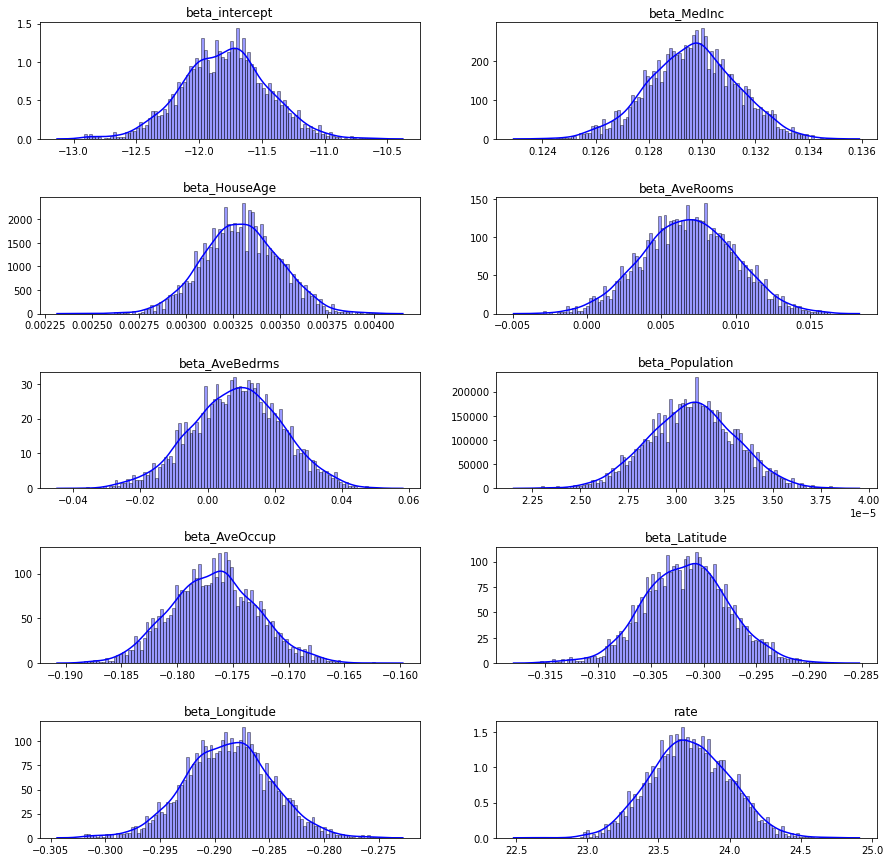

In [51]:
draw_coefficients(beta3_df, "11_gamma_scaled_coefficients")

We can notice a few interesting differences between the qualitative conclusions this model gives us as opposed to the normal distribution model:
* First, under the Normal distribution assumption, it seemed that the house price decreases for each additional room, but under the gamma distribution assumption, the price seems to increase.
* Second, under the normal distribution assumption, the price seems to increase for each additional bedroom of the house, but under the gamma distribution assumption, that conclusion does not seem as certain anymore. 

How do we interpret these coefficients?

Well, they now modify our price by a factor. Recall that our equation is now:

$$y = e^{\beta_0 + \beta_1x_1 + ... + \beta_nx_n}$$

which is equivalent to

$$y = e^{\beta_0}\times e^{\beta_1x_1}\times \dots \times e^{\beta_nx_n}$$

So each increase of `x_1` by one unit, will increases the house price by a factor of `e^{x_1}`.

For example, the mean value for `beta_AvgRooms` is ~0.135, so each additional room will increase the house price, on average, by a factor of e^0.135 = 1.14 (so if a house cost \\$250,000, adding an additional room would make its value \\$278,500).

Other parameters seem to qualitatively agree between the two models, but the model employing the gamma distribution is giving us better predictions on the unseen data.

There is still the problem of run-time, however. In general, if we want to do inference in reasonable time, we have to turn to the method of variational inference. 

## Faster Run-time with SVI

Pyro implements Stochastic Variational Inference (SVI) for faster inference. Under the SVI approach, instead of trying to sample from the posterior distribution directly, we simply optimize the parameters of some pre-defined distribution to match our observed data.

For example, we can choose to represent all our coefficients, and rate, as normal distributions. This way SVI simply needs to find an appropriate mean and standard deviation for each normal distribution such that it agrees with our data as much as possible.

In [52]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoDiagonalNormal

## Scale the data
#X_train_scaled = my_x_scaler.fit_transform(X_train)
#
#y_max = y_train.max()
#y_train_scaled = y_train/y_max
#

# Convert the data into tensors
X_train_torch = torch.tensor(X_train_scaled)
y_train_torch = torch.tensor(y_train_scaled)

pyro.clear_param_store()

# Provide a guide which fits a pre-defined distribution over each
# hidden parameter. The AutoDiagonalNormal guide fits a normal
# distribution over each coefficient and our rate parameter
my_guide = AutoDiagonalNormal(model_gamma)


# Initialize the SVI optimzation class
my_svi = SVI(model=model_gamma,
             guide= my_guide,
             optim=ClippedAdam({"lr": 0.01, 'clip_norm': 1.0}),
             loss=Trace_ELBO())

losses = []

start_time = time.time()

# Perform optimization
for i in range(5000):

    loss = my_svi.step(X_train_torch,
                       y_train_torch,  
                       california.feature_names)
    
    normalized_loss = loss/X_train_torch.shape[0]
    
    # Tabulate the loss for plotting
    losses.append(normalized_loss)
    if (i % 250 == 0):
        print(f'iter: {i}, normalized loss:{round(normalized_loss,2)}')
        
        

/Users/distiller/project/conda/conda-bld/pytorch_1591914893314/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


iter: 0, normalized loss:136943645477.45
iter: 250, normalized loss:-0.46
iter: 500, normalized loss:-0.67
iter: 750, normalized loss:-0.68
iter: 1000, normalized loss:-0.68
iter: 1250, normalized loss:-0.68
iter: 1500, normalized loss:-0.68
iter: 1750, normalized loss:-0.68
iter: 2000, normalized loss:-0.68
iter: 2250, normalized loss:-0.67
iter: 2500, normalized loss:-0.68
iter: 2750, normalized loss:-0.68
iter: 3000, normalized loss:-0.68
iter: 3250, normalized loss:-0.68
iter: 3500, normalized loss:-0.68
iter: 3750, normalized loss:-0.68
iter: 4000, normalized loss:-0.68
iter: 4250, normalized loss:-0.68
iter: 4500, normalized loss:-0.68
iter: 4750, normalized loss:-0.68


In [53]:
# To obtain samples for our coefficient distributions
# we need to use our optimized distributions to
# predict some new values
predictive = Predictive(model=model_gamma,
                        guide= my_guide,
                        num_samples=SAMPLE_NUMBER) 
with torch.no_grad():
    samples = predictive(X_train_torch,
                         y_train_torch,  
                         california.feature_names)

        
end_time = time.time()

print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Inference ran for 0.79 minutes


In [54]:
# TO DELETE
new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "time", 
                              "censored": True,
                              "value": round(end_time -  start_time, 2)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
608  MCMC scaled normal         R^2       0.0     0.550636
609   MCMC scaled gamma        time       1.0  1756.200000
610   MCMC scaled gamma         R^2       1.0     0.662587
611   MCMC scaled gamma         R^2       0.0     0.609426
612    SVI scaled gamma        time       1.0    47.270000

Grabbing the result from the SVI samples is a bit more involved than the MCMC samples since the samples return as a dictionary of tensors with gradients, and it also returns an additional key called `obs` which is not relevant for our analysis of the coefficients (it is a set of estimations for the training data).

In [55]:
samples.pop('obs').shape

torch.Size([3000, 16512])

In [56]:
beta_svi_df = pd.DataFrame(samples, index=range(SAMPLE_NUMBER)).applymap(lambda x: x[0].item())

In [57]:
#beta_svi_df = {}
#for key, values in samples.items():
#    if ("obs" not in key):
#        values = values.view(values.shape[0], )
#        
#        beta_svi_df[key] = values.detach()
#        
#beta_svi_df = pd.DataFrame(beta_svi_df)



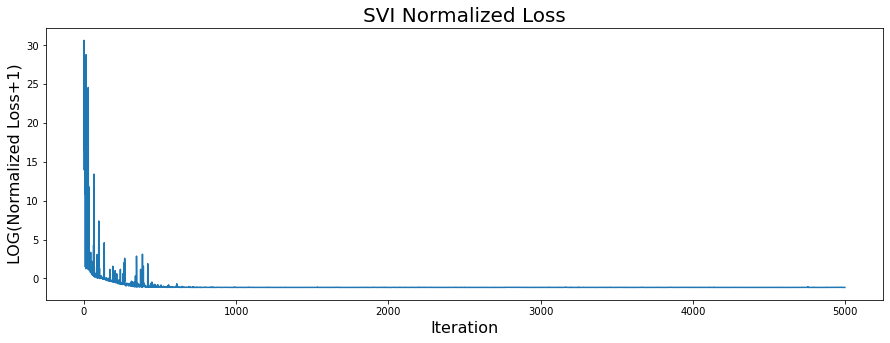

In [58]:
losses = np.array(losses)

plt.figure(figsize=(15,5))
plt.plot(np.log(losses+1))
plt.title("SVI Normalized Loss", size=20)
plt.xlabel("Iteration", size=16)
plt.ylabel("LOG(Normalized Loss+1)", size=16)

plt.savefig("images/12_SVI_loss.png")
plt.show()

In [59]:
beta_svi_df = create_beta_df(beta_svi_df, my_x_scaler, california.feature_names)
beta_svi_df['beta_intercept'] += np.log(y_censor_label)

In [60]:
linear_combination = predict_linear_combination(beta_svi_df, X_test)

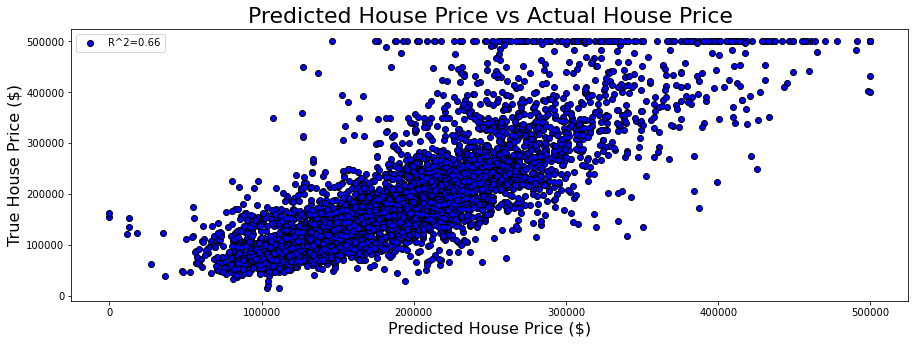

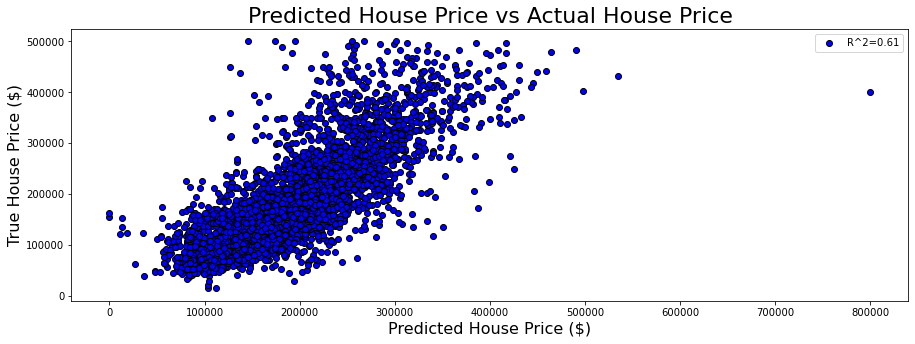

In [61]:
y_pred = np.exp(linear_combination)

plot_all_observations(y_test, y_pred, y_censor_label, "13_censored_gamma_scaled_SVI")
plot_uncensored_observations(y_test, y_pred, y_censor_label, "14_uncensored_gamma_scaled_SVI")

In [62]:
# TO DELETE
y_pred_censored = np.where(y_pred > y_censor_label, y_censor_label, y_pred)

new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "R^2", 
                              "censored": True,
                              "value": r2_score(y_test, y_pred_censored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored        value
609  MCMC scaled gamma        time       1.0  1756.200000
610  MCMC scaled gamma         R^2       1.0     0.662587
611  MCMC scaled gamma         R^2       0.0     0.609426
612   SVI scaled gamma        time       1.0    47.270000
613   SVI scaled gamma         R^2       1.0     0.662049

In [63]:
# TO DELETE
y_test_uncensored = y_test[y_test<y_censor_label]
y_pred_uncensored = y_pred[y_test<y_censor_label]


new_measurements = pd.Series({"model": "SVI scaled gamma", 
                              "measurement": "R^2", 
                              "censored": False,
                              "value": r2_score(y_test_uncensored, y_pred_uncensored)})

super_results = super_results.append(new_measurements, ignore_index=True)
super_results.tail()

model measurement  censored      value
610  MCMC scaled gamma         R^2       1.0   0.662587
611  MCMC scaled gamma         R^2       0.0   0.609426
612   SVI scaled gamma        time       1.0  47.270000
613   SVI scaled gamma         R^2       1.0   0.662049
614   SVI scaled gamma         R^2       0.0   0.608891

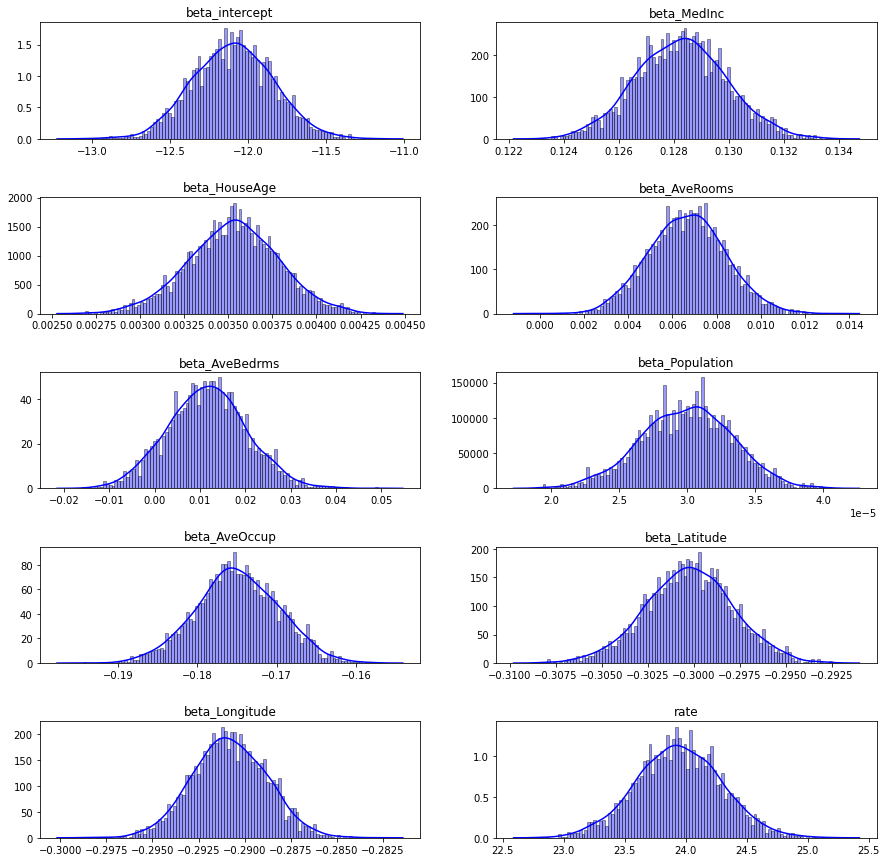

In [64]:
draw_coefficients(beta_svi_df, "15_scaled_gamma_SVI_coefficients")

In [65]:
super_end = time.time()

print(f'Notebook runtime: {round((super_end -  super_start)/60, 2)} minutes')

Notebook runtime: 62.09 minutes


In [66]:
super_results

model measurement  censored        value
0       Linear Regression        time       1.0     0.010000
1       Linear Regression         R^2       1.0     0.602542
2       Linear Regression         R^2       0.0     0.565252
3    MCMC unscaled normal        time       1.0  1523.540000
4    MCMC unscaled normal         R^2       1.0    -1.127828
..                    ...         ...       ...          ...
610     MCMC scaled gamma         R^2       1.0     0.662587
611     MCMC scaled gamma         R^2       0.0     0.609426
612      SVI scaled gamma        time       1.0    47.270000
613      SVI scaled gamma         R^2       1.0     0.662049
614      SVI scaled gamma         R^2       0.0     0.608891

[615 rows x 4 columns]

In [67]:
super_results.to_csv('experimental_measurement.csv', index=False)

In [68]:
R2_df = super_results[super_results['measurement'] == "R^2"]
grouped_R2_df = R2_df.groupby(['model', 'measurement', 'censored']).agg(['median', 'std']).reset_index()
grouped_R2_df

model measurement censored     value          
                                                median       std
0     Linear Regression         R^2      0.0  0.560481  0.193372
1     Linear Regression         R^2      1.0  0.614629  0.131310
2     MCMC scaled gamma         R^2      0.0  0.611613  0.021587
3     MCMC scaled gamma         R^2      1.0  0.662110  0.012306
4    MCMC scaled normal         R^2      0.0  0.560461  0.193295
5    MCMC scaled normal         R^2      1.0  0.614627  0.131246
6  MCMC unscaled normal         R^2      0.0 -1.377744  0.360277
7  MCMC unscaled normal         R^2      1.0 -1.041583  0.285184
8      SVI scaled gamma         R^2      0.0  0.610991  0.026077
9      SVI scaled gamma         R^2      1.0  0.662049  0.008649

In [69]:
censored_grouped_df = grouped_R2_df[grouped_R2_df['censored'] == True].sort_values(by=('value', 'median'))
uncensored_grouped_df = grouped_R2_df[grouped_R2_df['censored'] == False]

In [70]:
import plotly.graph_objects as go
models = censored_grouped_df['model']

fig = go.Figure(data=[
    go.Bar(name='Full Dataset', 
           x=censored_grouped_df['model'], 
           y=np.round(censored_grouped_df['value']['median'], 2), 
           error_y={"array":np.round(censored_grouped_df['value']['std'], 2)}),
    go.Bar(name='Uncensored Dataset', 
           x=uncensored_grouped_df['model'], 
           y=round(uncensored_grouped_df['value']['median'], 2), 
           error_y={"array":np.round(uncensored_grouped_df['value']['std'],2)})
])
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text='R² Across Different Models (Median ± std)',
                  xaxis_title="Model",
                  yaxis_title="R²",
                  legend_title="Censore Label",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
fig.update_yaxes(range=(-1.8, 1.0))
#fig.write_html('images/r_squared.html')
fig.write_image("images/r_squared.png", engine="kaleido", width=1000, scale=2)
fig.show()

In [71]:
positive_censored_grouped_df = censored_grouped_df[censored_grouped_df['model'] != "MCMC unscaled normal"]
positive_uncensored_grouped_df = uncensored_grouped_df[uncensored_grouped_df['model'] != "MCMC unscaled normal"]

In [72]:
display(positive_censored_grouped_df)
display(positive_uncensored_grouped_df)

model measurement censored     value          
                                              median       std
5  MCMC scaled normal         R^2      1.0  0.614627  0.131246
1   Linear Regression         R^2      1.0  0.614629  0.131310
9    SVI scaled gamma         R^2      1.0  0.662049  0.008649
3   MCMC scaled gamma         R^2      1.0  0.662110  0.012306

model measurement censored     value          
                                              median       std
0   Linear Regression         R^2      0.0  0.560481  0.193372
2   MCMC scaled gamma         R^2      0.0  0.611613  0.021587
4  MCMC scaled normal         R^2      0.0  0.560461  0.193295
8    SVI scaled gamma         R^2      0.0  0.610991  0.026077

In [73]:
import plotly.graph_objects as go
models = positive_censored_grouped_df['model']

fig = go.Figure(data=[
    go.Bar(name='Full Dataset', 
           x=positive_censored_grouped_df['model'], 
           y=np.round(positive_censored_grouped_df['value']['median'], 2), 
           error_y={"array":np.round(positive_censored_grouped_df['value']['std'], 2)}),
    go.Bar(name='Uncensored Dataset', 
           x=positive_uncensored_grouped_df['model'], 
           y=round(positive_uncensored_grouped_df['value']['median'], 2), 
           error_y={"array":np.round(positive_uncensored_grouped_df['value']['std'],2)})
])
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text="R² Across Different Models (Median ± std)",
                  xaxis_title="Model",
                  yaxis_title="R²",
                  legend_title="Censore Label",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
#fig.update_yaxes(range=(-1.5, 1.0))
#fig.write_html('images/r_squared2.html')
fig.write_image("images/r_squared2.png", engine="kaleido", width=1000, scale=2)
fig.show()

In [74]:
runtime_df = super_results[super_results['measurement'] == "time"]
grouped_runtime_df = runtime_df.groupby(['model', 'measurement', 'censored']).agg(['median', 'std']).reset_index()
grouped_runtime_df = grouped_runtime_df.sort_values(by=('value', 'median'))

In [75]:
import plotly.graph_objects as go
models = grouped_runtime_df['model']

fig = go.Figure(data=[
    go.Bar(x=models, 
           y=np.round(grouped_runtime_df['value']['median']/60.0, 2), 
           error_y={"array":np.round(grouped_runtime_df['value']['std']/60.0, 2)})
])
# Change the bar mode
fig.update_layout(barmode='group', 
                  title_text="Runtime Across Different Models (Median ± std)",#'Runtime Comparison across Different Models',
                  xaxis_title="Model",
                  yaxis_title="Runtime (minutes)",
                  font=dict(
                      family="Courier New, monospace",
                      size=18)
                 )
fig.write_html('images/runtimes.html')
fig.write_image("images/runtimes.png", engine="kaleido", width=1000, scale=2)
fig.show()

In [76]:
model_num = 5
super_results.shape[0]//(model_num*3)

41

In [77]:
#fig.write_image("images/fig1.png")

In [78]:
#fig.write_html("images/file.html")